In [23]:
import pandas as pd
import pylab as pl
import numpy as np
import re
import sys
import time
from __future__ import division
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns
%matplotlib inline

# Read and formatting the data

### Importing and formatting the data

In [6]:
def camel_to_snake(column_name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [7]:
def read_data(path):
    df = pd.read_csv(path, index_col=0)
    # convert each column name to snake case
    df.columns = [camel_to_snake(col) for col in df.columns]
    pd.melt(df)
    return df
df_origin = read_data('credit-data.csv')
df_origin.head(10)


,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,zipcode,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
PersonID,,,,,,,,,,,,
1,1,0.766127,45,60644,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,60637,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,60601,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,60601,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,60625,1,0.024926,63588.0,7,0,1,0,0.0
6,0,0.213179,74,60629,0,0.375607,3500.0,3,0,1,0,1.0
7,0,0.305682,57,60637,0,5710.000000,NaN,8,0,3,0,0.0
8,0,0.754464,39,60625,0,0.209940,3500.0,8,0,0,0,0.0
9,0,0.116951,27,60804,0,46.000000,NaN,2,0,0,0,NaN


# Data Preprocess - Handling Missing Values


###  Calculates how many values for each variable is null and prints the resulting table.

In [8]:
##  calculates how many values for each variable is null and prints the resulting table to stdout
def print_null_freq(df):
    df_lng = pd.melt(df)
    null_variables = df_lng.value.isnull()
    print(pd.crosstab(df_lng.variable, null_variables))
print_null_freq(df_origin)

value                                         False  True 
variable                                                  
age                                          150000      0
debt_ratio                                   150000      0
monthly_income                               120269  29731
number_of_dependents                         146076   3924
number_of_open_credit_lines_and_loans        150000      0
number_of_time30-59_days_past_due_not_worse  150000      0
number_of_time60-89_days_past_due_not_worse  150000      0
number_of_times90_days_late                  150000      0
number_real_estate_loans_or_lines            150000      0
revolving_utilization_of_unsecured_lines     150000      0
serious_dlqin2yrs                            150000      0
zipcode                                      150000      0


###  Fill the N/A ahead to better explore the data.
Mean is chosen here for it works better for the whole data set. Mean may not apply to number_of_dependents, but it won't be a huge problem for the further anaylsis, while fill with 0 will change a large portion of the data set which may casue more trouble.

In [9]:

def clean_feature(input_df):
    null_columns = input_df.columns[input_df.isnull().sum() > 10].tolist()
    for col in null_columns:
        replacement_value = input_df[col].mean()
        input_df[col] = input_df[col].fillna(replacement_value)

    result_df = input_df.dropna()
    return result_df

clean_feature(df_origin)

,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,zipcode,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
PersonID,,,,,,,,,,,,
1,1,0.766127,45,60644,2,0.802982,9120.000000,13,0,6,0,2.000000
2,0,0.957151,40,60637,0,0.121876,2600.000000,4,0,0,0,1.000000
3,0,0.658180,38,60601,1,0.085113,3042.000000,2,1,0,0,0.000000
4,0,0.233810,30,60601,0,0.036050,3300.000000,5,0,0,0,0.000000
5,0,0.907239,49,60625,1,0.024926,63588.000000,7,0,1,0,0.000000
6,0,0.213179,74,60629,0,0.375607,3500.000000,3,0,1,0,1.000000
7,0,0.305682,57,60637,0,5710.000000,6670.221237,8,0,3,0,0.000000
8,0,0.754464,39,60625,0,0.209940,3500.000000,8,0,0,0,0.000000
9,0,0.116951,27,60804,0,46.000000,6670.221237,2,0,0,0,0.757222


# Explore data

The esitmate probablilty of people have finance trouble in 2 years.

In [10]:
df_origin.serious_dlqin2yrs.mean()

0.06684

Function to get the overall describe summarise.

In [11]:
def describe(df):
    df_describe = df.describe()
    return df_describe

describe(df_origin)

,serious_dlqin2yrs,revolving_utilization_of_unsecured_lines,age,zipcode,number_of_time30-59_days_past_due_not_worse,debt_ratio,monthly_income,number_of_open_credit_lines_and_loans,number_of_times90_days_late,number_real_estate_loans_or_lines,number_of_time60-89_days_past_due_not_worse,number_of_dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,6.048438,52.295207,60648.810013,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,56.748197,4.192781,2037.818523,1.288045e+04,5.145951,4.169304,1.129771,4.155179,1.100404
min,0.000000,0.000000,0.000000,60601.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,60625.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,60629.000000,0.000000,0.366508,6.600000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,60644.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,60804.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Explore how age could impact the financal condition in two yeas.

In [12]:
describe(df_origin.age)

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

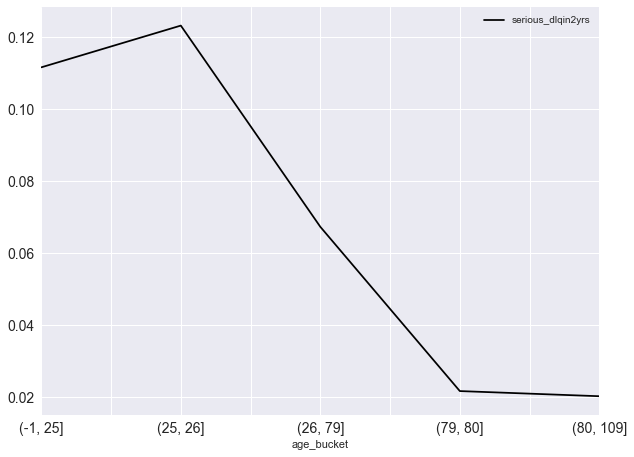

In [13]:
df_tmp = df_origin
df_tmp["age_bucket"] = pd.cut(df_tmp.age, range(-1, 110, 10))
buckets = [-1, 25] + [26, 79] + [80, 109]
df_tmp["age_bucket"] = pd.cut(df_tmp.age, buckets) 
pd.crosstab(df_tmp.age_bucket, df_tmp.serious_dlqin2yrs)
df_tmp[["age_bucket", "serious_dlqin2yrs"]].groupby("age_bucket").mean()
plot2 = df_tmp[["age_bucket", "serious_dlqin2yrs"]].groupby("age_bucket").mean().plot(color = "k", figsize=(10, 7.5),fontsize=14)

Explore how monthly income could impact the financal condition in two yeas.

In [14]:
describe(df_origin.monthly_income)

count    1.500000e+05
mean     6.670221e+03
std      1.288045e+04
min      0.000000e+00
25%      3.903000e+03
50%      6.600000e+03
75%      7.400000e+03
max      3.008750e+06
Name: monthly_income, dtype: float64

In [15]:
df_tmp = df_origin
df_tmp["income_bucket"] = pd.cut(df_tmp.monthly_income, range(-1, 3009000, 1000))
buckets = [-1, 2999] + [3000, 5999] + [6000, 8999]+[9000, 3009000]
df_tmp["income_bucket"] = pd.cut(df_tmp.monthly_income, buckets) 
pd.crosstab(df_tmp.income_bucket, df_tmp.serious_dlqin2yrs)


serious_dlqin2yrs,0,1
income_bucket,,
"(-1, 2999]",21219,2107
"(2999, 3000]",1588,170
"(3000, 5999]",38730,3326
"(5999, 6000]",1806,128
"(6000, 8999]",52677,3166
"(8999, 9000]",726,37
"(9000, 3009000]",23228,1092


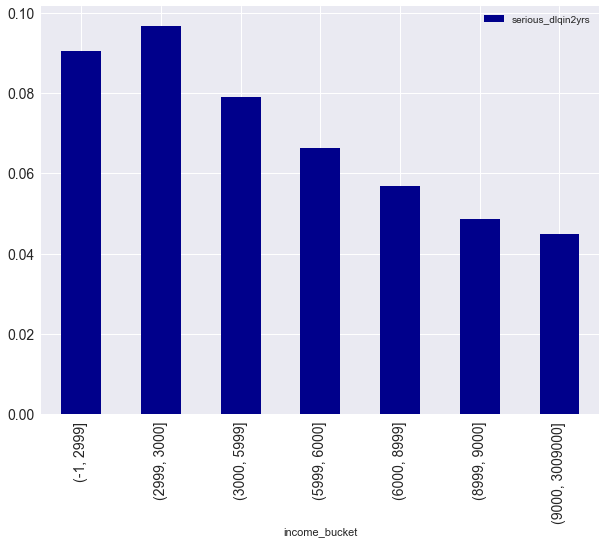

In [16]:
df_tmp[["income_bucket", "serious_dlqin2yrs"]].groupby("income_bucket").mean()
plot = df_tmp[["income_bucket", "serious_dlqin2yrs"]].groupby("income_bucket").mean().plot.bar(color='darkblue',figsize=(10, 7.5),fontsize=14)


Explore how dependents could impact the financal condition in two yeas.

In [17]:
df_tmp = df_origin
df_tmp['counts'] = df_tmp.groupby("number_of_dependents")[["zipcode"]].transform("count")
df_dependent = df_tmp[["number_of_dependents","counts"]].dropna().drop_duplicates().sort_values(by = 'counts', ascending = False)
df_dependent

,number_of_dependents,counts
PersonID,,
3,0.000000,86902
2,1.000000,26316
1,2.000000,19522
70,3.000000,9483
9,0.757222,3924
124,4.000000,2862
151,5.000000,746
448,6.000000,158
2025,7.000000,51


In [18]:
df_tmp = df_origin
df_tmp["dependents_bucket"] = pd.cut(df_tmp.number_of_dependents, range(-1, 20, 3))
buckets = [-1,0] + [1,2] + [3,4]+ [5,20]
df_tmp["dependents_bucket"] = pd.cut(df_tmp.number_of_dependents, buckets) 
pd.crosstab(df_tmp.dependents_bucket, df_tmp.serious_dlqin2yrs)

serious_dlqin2yrs,0,1
dependents_bucket,,
"(-1, 0]",81807,5095
"(0, 1]",28126,2114
"(1, 2]",17938,1584
"(2, 3]",8646,837
"(3, 4]",2565,297
"(4, 5]",678,68
"(5, 20]",214,31


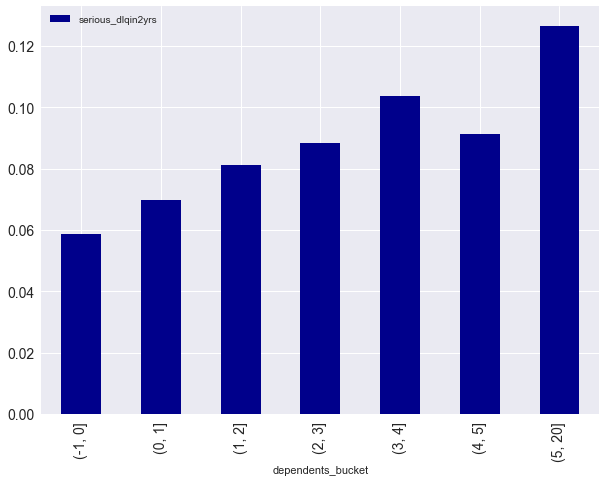

In [19]:
df_tmp[["dependents_bucket", "serious_dlqin2yrs"]].groupby("dependents_bucket").mean()
plot = df_tmp[["dependents_bucket", "serious_dlqin2yrs"]].groupby("dependents_bucket").mean().plot.bar(color='darkblue',figsize=(10, 7.5),fontsize=14)


# Generate features

In [20]:
def gen_binary_feature(df, column_name):
    df_result = pd.get_dummies(df[column_name])
    return df_result
gen_binary_feature(df_origin, 'number_of_dependents')

,0.0,0.757222267861,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,13.0,20.0
PersonID,,,,,,,,,,,,,,
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0


# Test classifier and evaluation please check the hw3.py